In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from scipy.io import loadmat        # to load mat files
import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for colour conversion
import tensorflow as tf             # for bulk image resize
import keras
import matplotlib.pyplot as plt
import numpy as np
import PIL
from time import process_time
from keras.models import Model
import keras
from keras import layers
from keras.models import Sequential
import pathlib
import os
import tensorflow as tf
import pickle
import keras_cv
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.utils import plot_model

#### Data Loading

In [2]:
# #Setting directory
# data_dir_train = pathlib.Path("./twoclasses/train/").with_suffix('')
# data_dir_val = pathlib.Path("./twoclasses/val/").with_suffix('')
# data_dir_test = pathlib.Path("./twoclasses/test/").with_suffix('')


data_dir_train = pathlib.Path("./final/train").with_suffix('')
data_dir_val = pathlib.Path("./final/val").with_suffix('')
data_dir_test = pathlib.Path("./final/test").with_suffix('')

In [3]:
#Setting batch size and heoght and width of images
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir_train,
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = keras.utils.image_dataset_from_directory(
  data_dir_val,
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 7088 files belonging to 7 classes.
Found 1515 files belonging to 7 classes.
Found 1527 files belonging to 7 classes.


In [5]:
#class names

class_names = train_ds.class_names
print("Class names in training data ",class_names)

class_names = val_ds.class_names
print("Class names in validation data ",class_names)

#class names

class_names = test_ds.class_names
print("Class names in test data ",class_names)

Class names in training data  ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']
Class names in validation data  ['clear', 'foggy_val', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']
Class names in test data  ['clear', 'foggy_test', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']


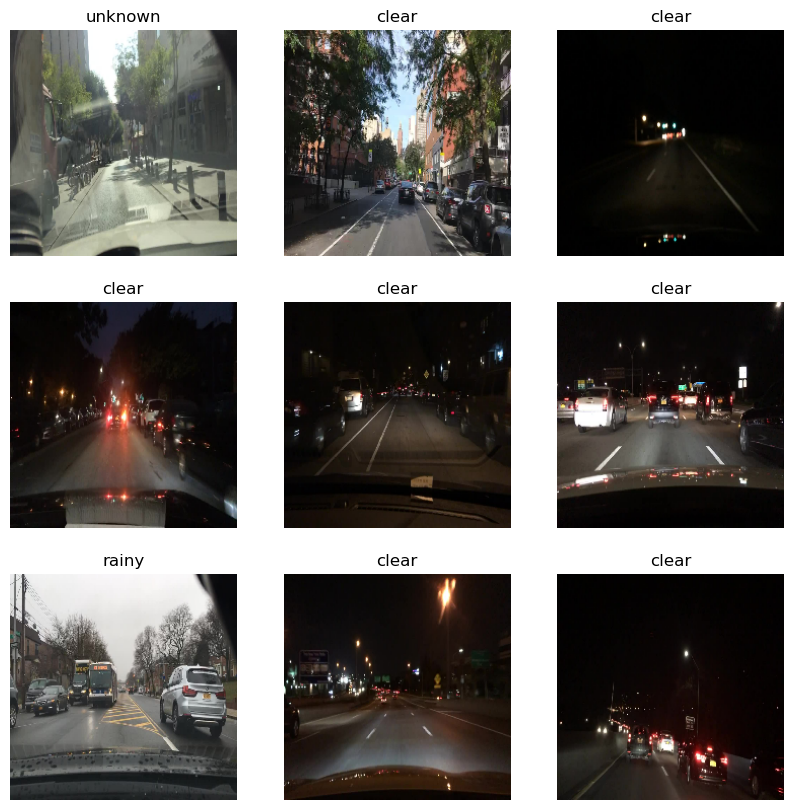

In [44]:
# Define the class names
class_names = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']

# Function to visualize augmented images with labels
def visualize_augmented_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = labels[i].numpy().astype(int)
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.show()

# Visualize augmented images with labels
visualize_augmented_images(train_ds)


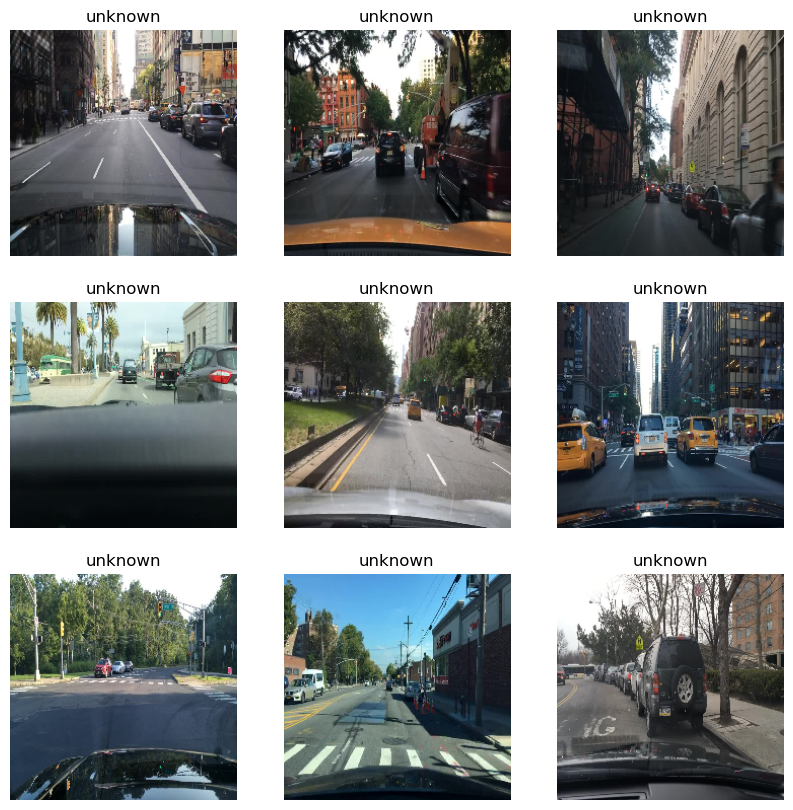

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the class names
class_names = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']

# Function to visualize random augmented images with labels of a specific class
def visualize_augmented_images(dataset, target_class='foggy', num_images=9):
    target_class_index = class_names.index(target_class)
    plt.figure(figsize=(10, 10))
    count = 0

    # Shuffle the dataset for randomness
    shuffled_dataset = dataset.shuffle(buffer_size=10000)
    
    for images, labels in shuffled_dataset:
        for i in range(len(images)):
            if count >= num_images:
                break
            if labels[i].numpy() == target_class_index:
                ax = plt.subplot(3, 3, count + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[target_class_index])
                plt.axis("off")
                count += 1
        if count >= num_images:
            break
    plt.show()

# Visualize random augmented images with labels for the "foggy" class
visualize_augmented_images(train_ds, target_class='unknown')

#### Data Augmentation

In [10]:
# Define the data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomZoom(0.2, 0.2),
        layers.RandomContrast(0.8)
    ],
    name="data_augmentation",
)

# Apply the data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

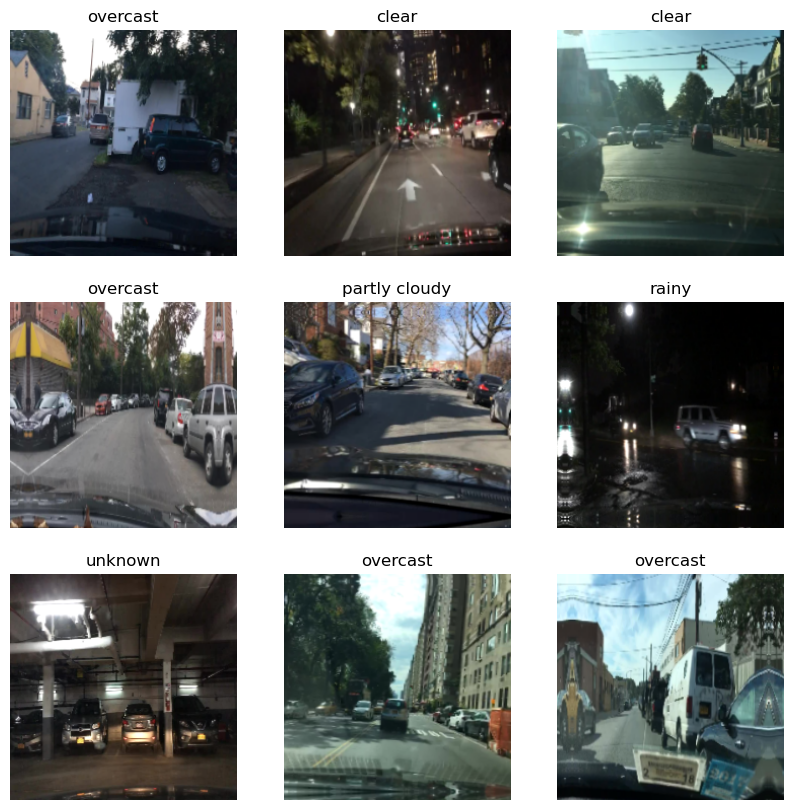

In [11]:
# Define the class names
class_names = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']

# Function to visualize augmented images with labels
def visualize_augmented_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = labels[i].numpy().astype(int)
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.show()

# Visualize augmented images with labels
visualize_augmented_images(augmented_train_ds)

#### From scratch

In [22]:
# # network input, images are 32 pixels square, and colour; so our size is 32 x 32 x 3
# inputs = keras.Input(shape=(120, 120, 3, ), name='img')

# # put the rest of the network in here
# # first conv group
# x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
# x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # second conv group
# x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
# x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # third conv group
# x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
# x = layers.Conv2D(filters=64, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # fourth conv group
# x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
# x = layers.Conv2D(filters=128, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # dense layers
# x = layers.Flatten()(x)
# x = layers.Dense(512, activation='relu')(x)
# #x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.25)(x)

# # the output, 10 neurons for 10 classes, and a softmax activation
# outputs = layers.Dense(2, activation='softmax')(x)

# # build the model, and print a summary
# vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg')
# vgg.summary()

In [23]:
# vgg.compile(
#         # categorical cross entropy loss
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#         # adam optimiser
#         optimizer=keras.optimizers.Adam(),
#         # compute the accuracy metric, in addition to the loss 
#         metrics=['accuracy'], jit_compile=False)
# history = vgg.fit(train_ds, batch_size=16, epochs=10, verbose=True, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)])

#### From scratch using class_weights

In [ ]:
# # network input, images are 32 pixels square, and colour; so our size is 32 x 32 x 3
# inputs = keras.Input(shape=(72, 128, 3, ), name='img')

# # put the rest of the network in here
# # first conv group
# x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
# x = layers.Conv2D(filters=16, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # second conv group
# x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
# x = layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # third conv group
# x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
# x = layers.Conv2D(filters=64, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # fourth conv group
# x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
# x = layers.Conv2D(filters=128, kernel_size=(3,3), activation=None, padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.SpatialDropout2D(0.25)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

# # dense layers
# x = layers.Flatten()(x)
# x = layers.Dense(512, activation='relu')(x)
# #x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.25)(x)

# # the output, 10 neurons for 10 classes, and a softmax activation
# outputs = layers.Dense(1, activation='sigmoid')(x)

# # build the model, and print a summary
# vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg')
# vgg.summary()

In [ ]:
# # Inverse of class frequencies
# # Define the class frequencies
# class_frequencies = [3742, 100, 867, 516, 516, 518, 809]

# # Calculate total number of samples
# total_samples = sum(class_frequencies)

# # Calculate class weights
# class_weights = {}
# for i, freq in enumerate(class_frequencies):
#     class_weights[i] = total_samples / (len(class_frequencies) * freq)

# print("Class Weights:", class_weights)

In [ ]:
# # Train the model with class weights
# vgg.compile(
#         # categorical cross entropy loss
#         loss=keras.losses.BinaryCrossentropy(),
#         # adam optimiser
#         optimizer=keras.optimizers.Adam(),
#         # compute the accuracy metric, in addition to the loss 
#         metrics=['accuracy'], jit_compile=False)

# history = vgg.fit(
#     train_ds,
#     batch_size=100,
#     epochs=10,
#     validation_data=val_ds,
#     verbose=True,
#     callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)],
#     class_weight=class_weights
# )

In [32]:
# # testing segmentation
# y_seg_test = np.concatenate([y[1] for x,y in test_class_seg.as_numpy_iterator()])
# class_preds, seg_preds = new_model.predict(test_class_seg)
# seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
# seg_gt_flat = y_seg_test.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector
# cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat, normalize='true') * 100
# print(cm)


# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='.2f', cmap='vlag')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Fine-Tuned Semantic Segmentation, F1 Score: %f' % f1_score(seg_gt_flat, seg_preds_flat, average='weighted'))
# plt.show()

#### Resnet18 Pretrained

In [55]:
# Input shape
input_data = keras.Input(shape=(224, 224, 3), name='img')

# Pretrained backbone
backbone = keras_cv.models.ResNetBackbone.from_preset("resnet18")

for layer in backbone.layers[:10]:
    layer.trainable = False

In [56]:
for layer in backbone.layers[:11]:
    print(layer, layer.trainable)

<InputLayer name=input_layer_5, built=True> False
<Rescaling name=rescaling_4, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=v2_stack_0_block1_1_conv, built=True> False
<BatchNormalization name=v2_stack_0_block1_1_bn, built=True> False
<Activation name=v2_stack_0_block1_1_relu, built=True> False
<Conv2D name=v2_stack_0_block1_2_conv, built=True> False
<BatchNormalization name=v2_stack_0_block1_2_bn, built=True> True


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_backbone                │ (None, 7, 7, 512)      │    11,186,112 │
│ (ResNetBackbone)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,406,215 (54.96 MB)

 Trainable params: 14,313,223 (54.60 MB)

 Non-trainable params: 92,992 (363.25 KB)

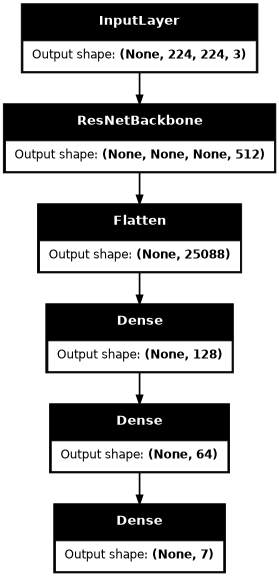

In [57]:
# Pass the input data through the backbone
backbone_output = backbone(input_data)

# Custom layers
# x = layers.GlobalAveragePooling2D()(backbone_output)
x = layers.Flatten()(backbone_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.25)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create the full model
model_resnet18 = Model(inputs=input_data, outputs=outputs)

# Print the model summary
model_resnet18.summary()
plot_model(model_resnet18, show_shapes=True, dpi=60)

In [69]:
# Inverse of class frequencies
# Define the class frequencies
class_frequencies = [3742, 100, 867, 516, 516, 518, 809]

# Calculate total number of samples
total_samples = sum(class_frequencies)

# Calculate class weights
class_weights = {}
for i, freq in enumerate(class_frequencies):
    class_weights[i] = total_samples / (len(class_frequencies) * freq)

print("Class Weights:", class_weights)

Class Weights: {0: 0.26983278613422923, 1: 10.097142857142858, 2: 1.1646070192782996, 3: 1.956810631229236, 4: 1.956810631229236, 5: 1.9492553778268065, 6: 1.2481017128730354}


In [32]:
# for layer in backbone.layers:
#     print(layer, layer.trainable)

In [36]:
# Train the model with class weights
model_resnet18.compile(
        # categorical cross entropy loss
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        # adam optimiser
        optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
        # compute the accuracy metric, in addition to the loss 
        metrics=[keras.metrics.sparse_categorical_crossentropy], jit_compile=False)

train_start = process_time()

history = model_resnet18.fit(
    augmented_train_ds,
    epochs=30,
    validation_data=val_ds,
    verbose=True,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)]
)

train_end = process_time()

Epoch 1/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 86s 363ms/step - loss: 1.4787 - sparse_categorical_crossentropy: 1.4787 - val_loss: 1.7907 - val_sparse_categorical_crossentropy: 1.7940
Epoch 2/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 80s 360ms/step - loss: 1.1676 - sparse_categorical_crossentropy: 1.1676 - val_loss: 1.8289 - val_sparse_categorical_crossentropy: 1.8277
Epoch 3/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 80s 360ms/step - loss: 1.1129 - sparse_categorical_crossentropy: 1.1129 - val_loss: 1.4490 - val_sparse_categorical_crossentropy: 1.4486
Epoch 4/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 81s 364ms/step - loss: 1.0699 - sparse_categorical_crossentropy: 1.0699 - val_loss: 1.1557 - val_sparse_categorical_crossentropy: 1.1560
Epoch 5/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 81s 363ms/step - loss: 1.0284 - sparse_categorical_crossentropy: 1.0284 - val_loss: 1.0733 - val_sparse_categorical_crossentropy: 1.0695
Epoch 6/30
222/222 ━━━━━━━━━━━━━━━━━━━━ 81s 361ms/step - loss: 1.0059 - sparse_categorical_crossentropy: 1.0059 - v

In [37]:
final_train_time = train_end - train_start
print(final_train_time)

1912.2800323189995


In [38]:
y_train = np.concatenate([y for x,y in train_ds.as_numpy_iterator()])
y_test = np.concatenate([y for x,y in test_ds.as_numpy_iterator()])

#print(y_class_test.shape)
pred_time_train = process_time()
train_pred = model_resnet18.predict(train_ds)
pred_time_end = process_time()

pred_end_train = pred_time_end - pred_time_train

pred_time_test = process_time()
test_pred = model_resnet18.predict(test_ds)
pred_end_test = process_time()

pred_end_test = pred_end_test - pred_time_test

print("Train time:", pred_end_train)
print("Test time:", pred_end_test)

#print(test_pred)

222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Train time: 31.770169351999357
Test time: 6.66358154199952


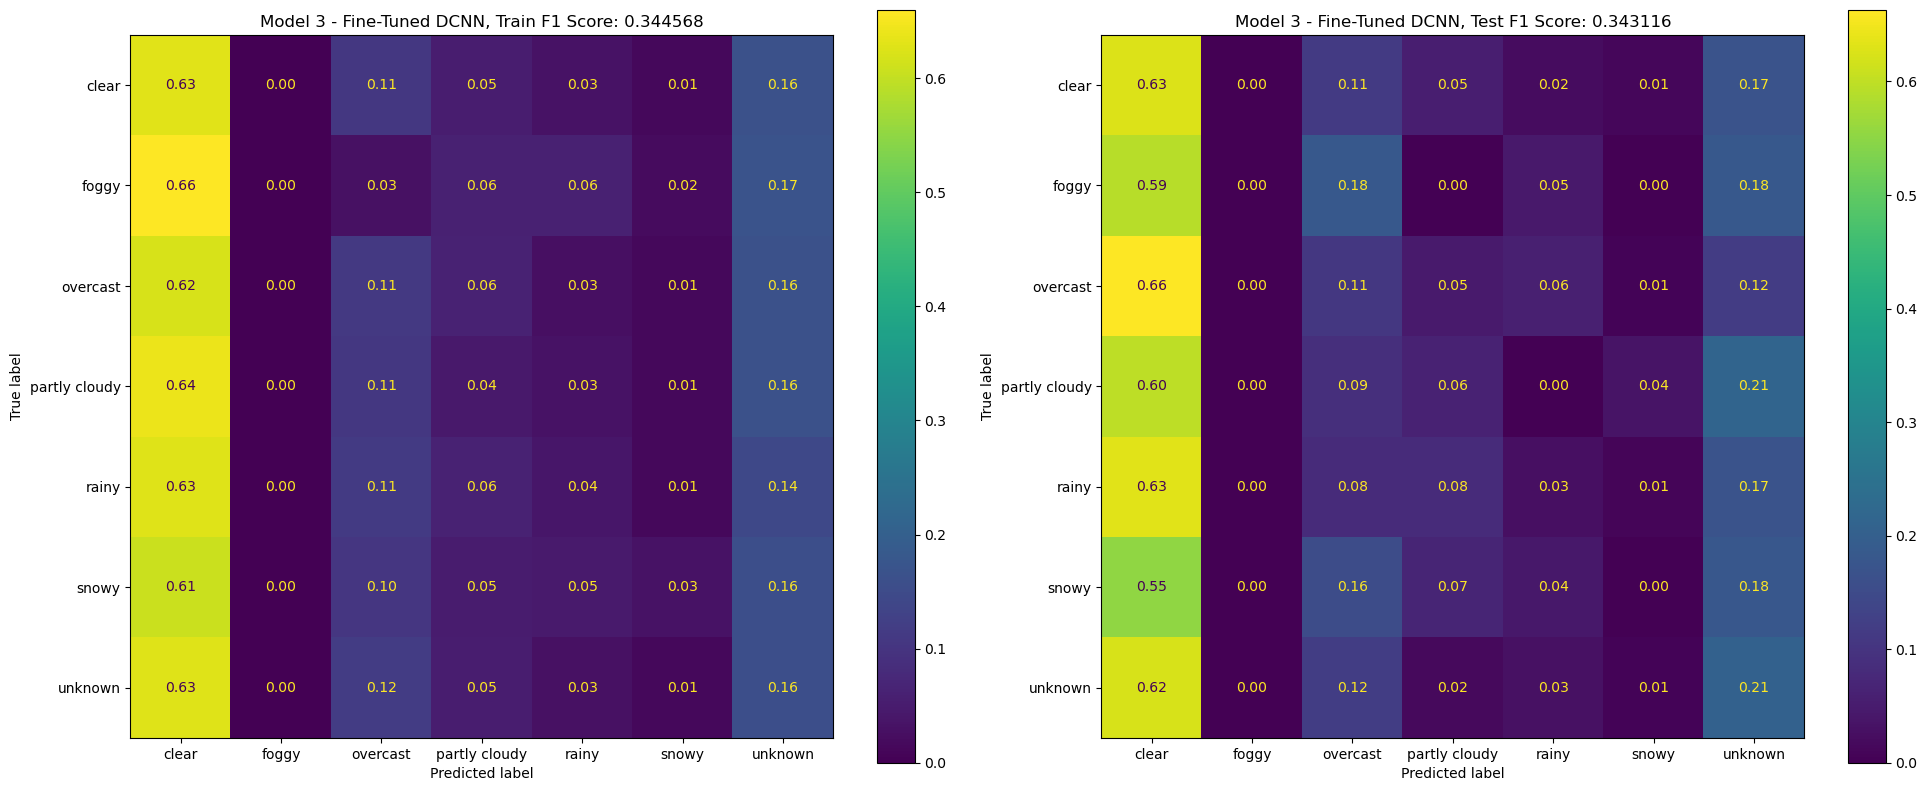

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import tensorflow as tf

# Define class names
class_names = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']

# Convert predictions to class labels
train_pred_labels = np.argmax(train_pred, axis=1)
test_pred_labels = np.argmax(test_pred, axis=1)

# Compute confusion matrices
train_confusion_mtx = confusion_matrix(y_train, train_pred_labels, normalize='true')
test_confusion_mtx = confusion_matrix(y_test, test_pred_labels, normalize='true')

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=[20, 8])

# Plot the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mtx, display_labels=class_names)
disp_train.plot(ax=axes[0], values_format='.2f')
train_f1 = f1_score(y_train, train_pred_labels, average='weighted')
axes[0].set_title('Model 3 - Fine-Tuned DCNN, Train F1 Score: %f' % train_f1)

# Plot the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mtx, display_labels=class_names)
disp_test.plot(ax=axes[1], values_format='.2f')
test_f1 = f1_score(y_test, test_pred_labels, average='weighted')
axes[1].set_title('Model 3 - Fine-Tuned DCNN, Test F1 Score: %f' % test_f1)

# Display the plot
plt.tight_layout()
plt.show()


In [20]:
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
# import seaborn as sns
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=[12, 8])    
# ax = fig.add_subplot(1, 1, 1)
# indexes = tf.argmax(train_pred, axis=1)
# confusion_mtx = tf.math.confusion_matrix(y_train, indexes) 
# sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
# ax.set_title('DCNN, Train F1 Score: %f' % f1_score(y_train, indexes, average='weighted'))

# fig = plt.figure(figsize=[12, 8])    
# ax = fig.add_subplot(1, 1, 1)
# indexes = tf.argmax(test_pred, axis=1)
# confusion_mtx = tf.math.confusion_matrix(y_test, indexes) 
# sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
# ax.set_title('DCNN, Test F1 Score: %f' % f1_score(y_test, indexes, average='weighted'))

In [ ]:
# cm = sklearn.metrics.confusion_matrix(y_train, , normalize='true') * 100
# print(cm)


# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='.2f', cmap='vlag')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Fine-Tuned Semantic Segmentation, F1 Score: %f' % f1_score(seg_gt_flat, seg_preds_flat, average='weighted'))
# plt.show()

KeyError: 'accuracy'

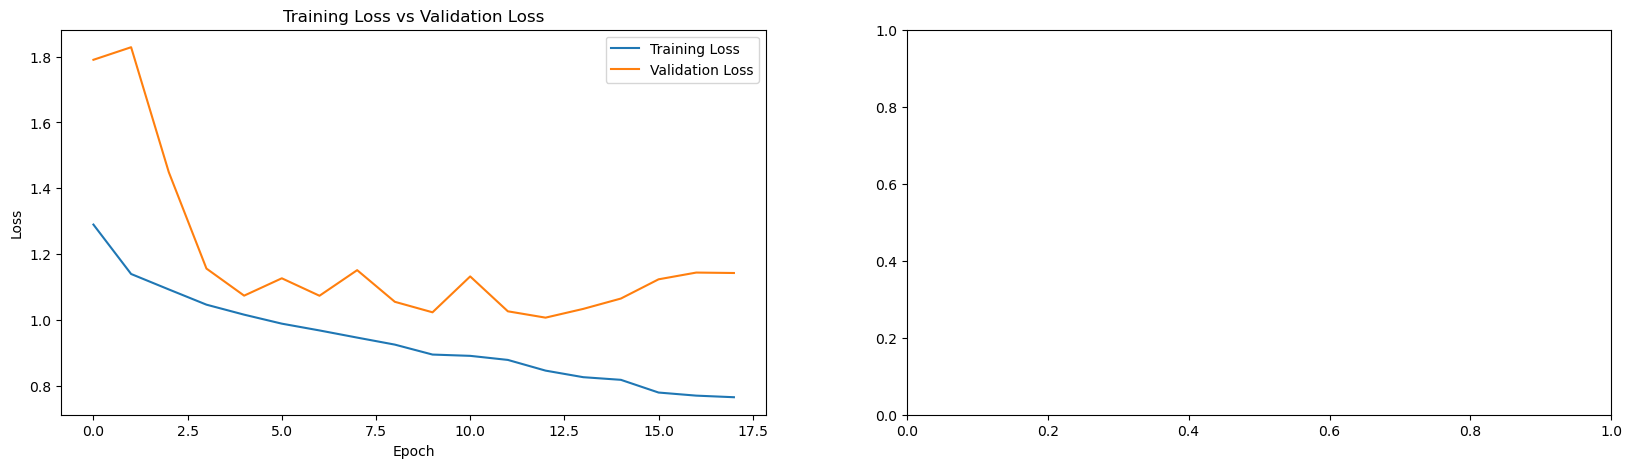

In [48]:
def plot_training(history):
    fig = plt.figure(figsize=[20, 5])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss vs Validation Loss')
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Train Accuracy")
    ax.plot(history.history['val_accuracy'], label="Val Accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Accuracy vs Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_training(history)

In [54]:
class ArcFace(keras.Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = None

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)
        print(self.W)

    def call(self, inputs, training=None):
        x, y = inputs
        c = keras.ops.shape(x)[-1]
        # normalize feature
        x = keras.utils.normalize(x, order=2, axis=1)
        # normalize weights
        W = keras.utils.normalize(self.W, order=2, axis=0)
        # dot product
        logits = keras.ops.matmul(x, W)
        
        # add margin
        # clip logits to prevent zero division when backward
        theta = keras.ops.arccos(keras.ops.clip(logits, -1.0 + keras.config.epsilon(), 1.0 - keras.config.epsilon()))
        target_logits = keras.ops.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = keras.ops.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)

In [ ]:
# Input shape
input_data = keras.Input(shape=(224, 224, 3), name='img')

# Pretrained backbone
backbone = keras_cv.models.ResNetBackbone.from_preset("resnet18")

for layer in backbone.layers[:10]:
    layer.trainable = False
    
# Pass the input data through the backbone
backbone_output = backbone(input_data)

embedding_size = 32
embedding_layer = layers.Dense(embedding_size, activation=None, name='embedding')(backbone_output)

# Custom layers
# x = layers.GlobalAveragePooling2D()(backbone_output)
x = layers.Flatten()(backbone_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.25)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create the full model
model_resnet18 = Model(inputs=input_data, outputs=outputs)

# Print the model summary
model_resnet18.summary()



#base_network = keras.Model(dummy_input, embedding_layer, name='base_network')
#base_network.compile(jit_compile=False)

#inp = keras.Input((28, 28, 1))
label = keras.Input(shape=(10,))
#embedding = base_network(inp)
embedding_layer = layers.BatchNormalization()(embedding_layer)
#embedding = layers.Activation('relu')(embedding)
output = ArcFace(n_classes=10)([embedding_layer, label])
arc_network = keras.Model([dummy_input, label], output, name='arc')

arc_network.summary()
arc_network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], jit_compile=False)

##### Resnet with unfreezing last 10 layers

In [ ]:
import keras
from keras import layers
from keras.models import Model
import keras_cv.models
from tensorflow.keras.optimizers import Adam

# Enable mixed precision if necessary
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# Input shape
input_data = keras.Input(shape=(72, 128, 3,), name='img')

# Load pretrained backbone
backbone = keras_cv.models.ResNetBackbone.from_preset("resnet18")

# # Freeze all layers in the backbone initially
# for layer in backbone.layers:
#     layer.trainable = False

# # Unfreeze specific layers for fine-tuning
# for layer in backbone.layers[-10:]:  # Unfreeze the last 10 layers as an example
#     layer.trainable = True

# Pass the input data through the backbone
backbone_output = backbone(input_data)

# Add custom layers
x = layers.Flatten()(backbone_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.25)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create the full model
model = Model(inputs=input_data, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Example training call
# model.fit(train_data, train_labels, batch_size=32, epochs=10, validation_data=(val_data, val_labels))


In [ ]:
# Train the model with class weights
model.compile(
        # categorical cross entropy loss
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        # adam optimiser
        optimizer=keras.optimizers.Adam(),
        # compute the accuracy metric, in addition to the loss 
        metrics=['accuracy'], jit_compile=False)

history = model.fit(
    train_ds,
    batch_size=32,
    epochs=30,
    validation_data=val_ds,
    verbose=True,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)]
    #class_weight=class_weights
)

In [ ]:
y_class_test = np.concatenate([y for x,y in test_ds.as_numpy_iterator()])
y_train_test = np.concatenate([y for x,y in train_ds.as_numpy_iterator()])


print(y_class_test.shape)


test_pred = model.predict(test_ds)
train_pred = model.predict(train_ds)


print(test_pred)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[12, 8])    
ax = fig.add_subplot(1, 1, 1)
indexes = tf.argmax(test_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_class_test, indexes) 
sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
ax.set_title('DCNN, Test F1 Score: %f' % f1_score(y_class_test, indexes, average='weighted'))

fig = plt.figure(figsize=[12, 8])    
ax = fig.add_subplot(1, 1, 1)
indexes = tf.argmax(train_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_train_test, indexes) 
sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
ax.set_title('DCNN, Train F1 Score: %f' % f1_score(y_train_test, indexes, average='weighted'))

#### Mobilenet small

In [ ]:
model = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_large_imagenet",
)

In [28]:
import keras
from keras import layers
from keras.models import Model
import keras_cv.models
from tensorflow.keras.optimizers import Adam

# Enable mixed precision if necessary
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# Input shape
input_data = keras.Input(shape=(224, 224, 3), name='img')

# Load pretrained backbone
backbone = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_small_imagenet",
)

#backbone.trainable = False

# # Freeze all layers in the backbone initially
# for layer in backbone.layers:
#     layer.trainable = False

# # Unfreeze specific layers for fine-tuning
# for layer in backbone.layers[-10:]:  # Unfreeze the last 10 layers as an example
#     layer.trainable = True

# Pass the input data through the backbone
backbone_output = backbone(input_data)

# Add custom layers
x = layers.Flatten()(backbone_output)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.25)(x)
outputs = layers.Dense(2, activation='softmax')(x)

# Create the full model
model = Model(inputs=input_data, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'], jit_compile = False)

# Print the model summary
model.summary()

# Example training call
# model.fit(train_data, train_labels, batch_size=32, epochs=10, validation_data=(val_data, val_labels))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobile_net_v3_small_backbone    │ (None, 7, 7, 576)      │       939,120 │
│ (MobileNetV3Backbone)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,806,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,745,650 (10.47 MB)

 Trainable params: 2,733,538 (10.43 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3),
    ModelCheckpoint(filepath='best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
]

In [30]:
history_mobilenet = model.fit(
    train_ds,
    batch_size=32,
    epochs=20,
    validation_data=val_ds,
    verbose=True,
    callbacks=callbacks
    #class_weight=class_weights
)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.8532 - loss: 1.2610 - val_accuracy: 0.8793 - val_loss: 0.6097
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.8771 - loss: 0.3982 - val_accuracy: 0.8793 - val_loss: 0.8261
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.8867 - loss: 0.2163 - val_accuracy: 0.8793 - val_loss: 0.9522
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9025 - loss: 0.1958 - val_accuracy: 0.8793 - val_loss: 0.6040
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.9301 - loss: 0.1863 - val_accuracy: 0.8057 - val_loss: 0.4254
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.8604 - loss: 0.2795 - val_accuracy: 0.7377 - val_loss: 0.8249
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9520 - loss: 0.1421 - val_accuracy: 0.5565 - val_loss: 2.0195
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.9526 - loss: 0

In [31]:
y_test = np.concatenate([y for x,y in test_ds.as_numpy_iterator()])
y_train = np.concatenate([y for x,y in train_ds.as_numpy_iterator()])

In [32]:
test_pred = model.predict(test_ds)
train_pred = model.predict(train_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


Text(0.5, 1.0, 'DCNN, Train F1 Score: 0.773525')

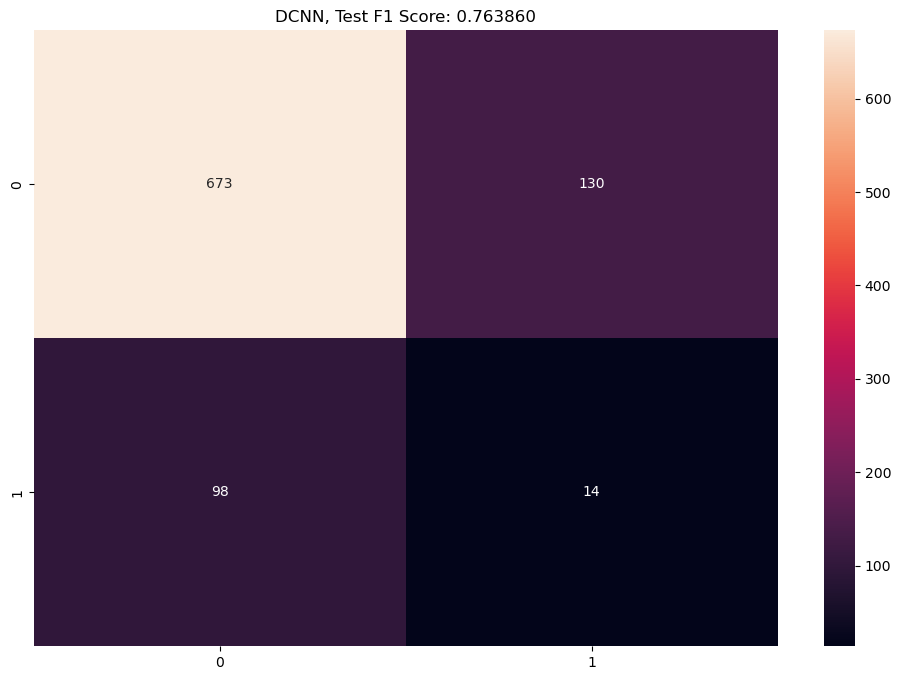

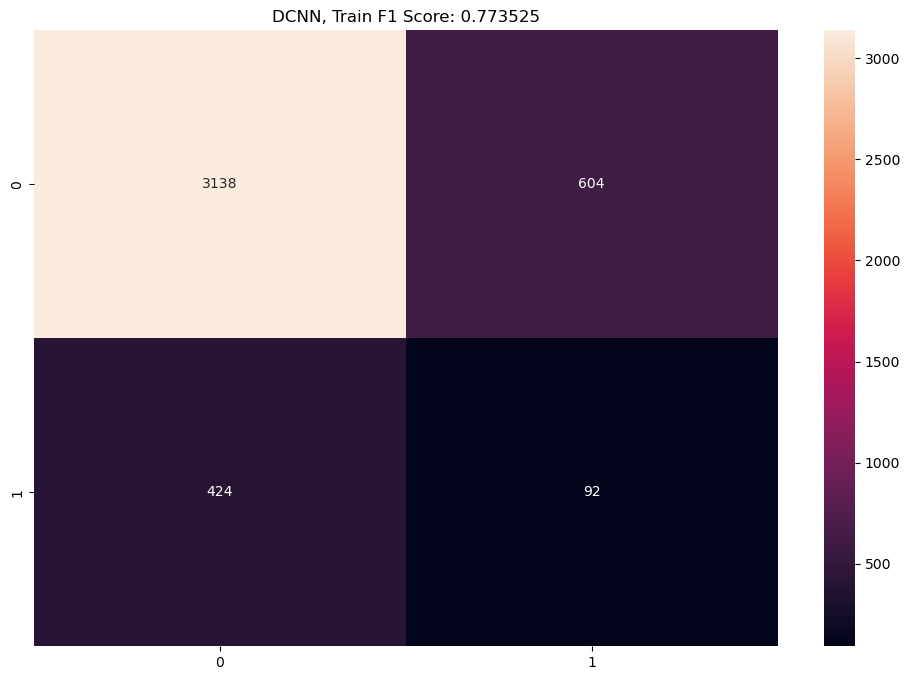

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[12, 8])    
ax = fig.add_subplot(1, 1, 1)
indexes = tf.argmax(test_pred, axis=1)
#print(indexes)
#print(y_test)
confusion_mtx = tf.math.confusion_matrix(y_test, indexes) 
sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
ax.set_title('DCNN, Test F1 Score: %f' % f1_score(y_test, indexes, average='weighted'))

fig = plt.figure(figsize=[12, 8])    
ax = fig.add_subplot(1, 1, 1)
indexes = tf.argmax(train_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_train, indexes) 
sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
ax.set_title('DCNN, Train F1 Score: %f' % f1_score(y_train, indexes, average='weighted'))

In [34]:
def plot_training(history):
    fig = plt.figure(figsize=[20, 5])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss vs Validation Loss')
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Train Accuracy")
    ax.plot(history.history['val_accuracy'], label="Val Accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training Accuracy vs Validation Accuracy')
    ax.legend()

    plt.show()

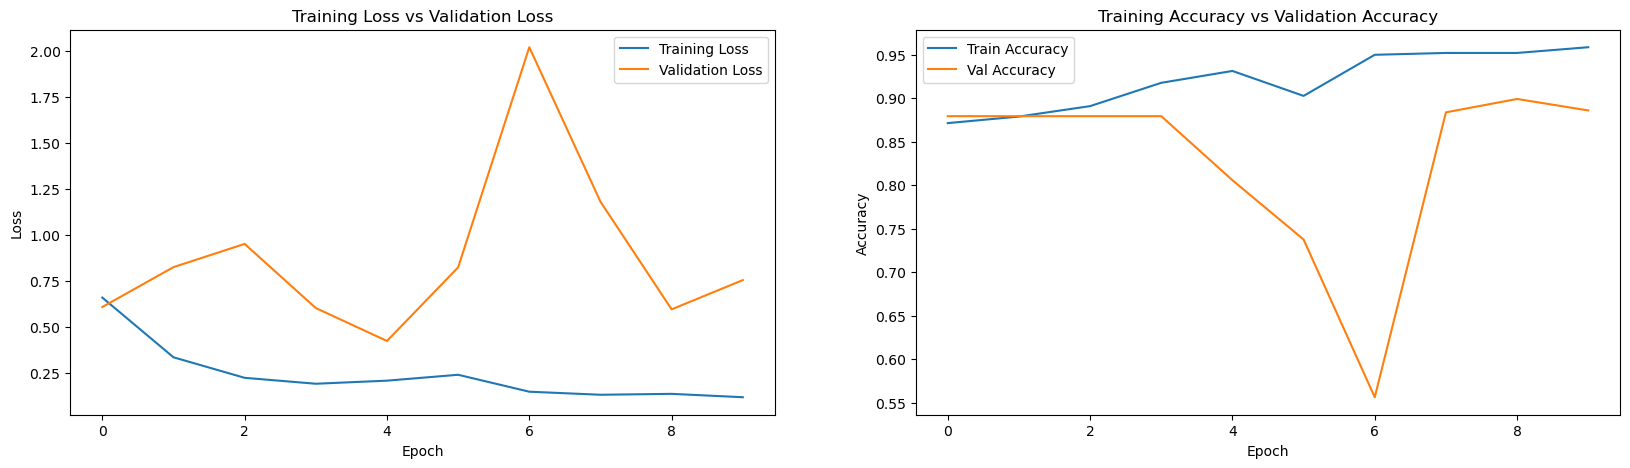

In [35]:
plot_training(history_mobilenet)

#### SMOTE

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Load the dataset
train_ds = keras.utils.image_dataset_from_directory(
  './final/train/',  # Change this to your actual data path
  seed=41,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Convert the dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, y_train = dataset_to_numpy(train_ds)

# Flatten images if needed and normalize pixel values
X_train = X_train.reshape((X_train.shape[0], -1)) / 255.0

Found 7088 files belonging to 7 classes.


In [ ]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Reshape X_train_resampled back to the original image shape
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], img_height, img_width, 3))

# Convert y_train_resampled to a categorical format if necessary
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled, num_classes=num_classes)

# Create a TensorFlow dataset from the resampled data
train_ds_resampled = tf.data.Dataset.from_tensor_slices((X_train_resampled, y_train_resampled)).batch(batch_size)

In [ ]:
#Distribution of training data

# Extract labels from the dataset
labels = np.concatenate([y.numpy() for _, y in train_ds_resampled])
#print(labels)

# Calculate class distribution
unique_classes, class_counts = np.unique(labels, return_counts=True)

classnames = train_ds_resampled.class_names

# print(unique_classes)
# print(class_counts)
# print(classnames)

# Plot the distribution
fig, ax = plt.subplots()
bar_container = ax.bar(classnames, class_counts)
ax.set(xlabel = 'Class', ylabel='Count', title='Class Distribution of training data')
ax.set_xticklabels(classnames,rotation = 45) #rotating 45 degree

ax.bar_label(bar_container, fmt='{:,.0f}')
plt.show()

In [ ]:
# Input shape
input_data = keras.Input(shape=(224, 224, 3), name='img')

# Pretrained backbone
backbone = keras_cv.models.ResNetBackbone.from_preset("resnet18")

# Pass the input data through the backbone
backbone_output = backbone(input_data)

# Custom layers
x = layers.Flatten()(backbone_output)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.25)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create the full model
model = Model(inputs=input_data, outputs=outputs)

# Print the model summary
model.summary()

In [ ]:
# Train the model with class weights
model.compile(
        # categorical cross entropy loss
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        # adam optimiser
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        # compute the accuracy metric, in addition to the loss 
        metrics=['accuracy'], jit_compile=False)

history = model.fit(
    train_ds_resampled,
    batch_size=8,
    epochs=10,
    validation_data=val_ds,
    verbose=True,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)]
)

#### Using Oversampling/undersampling

In [9]:
# import numpy as np

# def dataset_to_numpy(dataset):
#     images = []
#     labels = []
    
#     for img, label in dataset.unbatch().take(len(dataset)):
#         images.append(img.numpy())
#         labels.append(label.numpy())
        
#     return np.array(images), np.array(labels)

# train_images, train_labels = dataset_to_numpy(train_ds)

In [24]:
!pip install imbalanced-learn
# from imblearn.over_sampling import RandomOverSampler

# # Reshape train_images to 2D if necessary (e.g., for SMOTE)
# n_samples, img_height, img_width, n_channels = train_images.shape
# X = train_images.reshape((n_samples, img_height * img_width * n_channels))

# # Apply RandomOverSampler
# ros = RandomOverSampler(random_state=41)
# X_resampled, y_resampled = ros.fit_resample(X, train_labels)

# # Reshape X_resampled back to the original shape
# X_resampled = X_resampled.reshape((len(X_resampled), img_height, img_width, n_channels))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 66.8 MB/s eta 0:00:00


In [7]:
# import tensorflow as tf

# def numpy_to_dataset(images, labels, batch_size):
#     dataset = tf.data.Dataset.from_tensor_slices((images, labels))
#     dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size)
#     return dataset

# oversampled_train_ds = numpy_to_dataset(X_resampled, y_resampled, batch_size)

In [6]:


# # Assuming classnames are known
# classnames = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'] 

# # Extract labels from the oversampled dataset
# labels = np.concatenate([y.numpy() for _, y in oversampled_train_ds])

# # Calculate class distribution
# unique_classes, class_counts = np.unique(labels, return_counts=True)

# # Plot the distribution
# fig, ax = plt.subplots()
# bar_container = ax.bar(classnames, class_counts)
# ax.set(xlabel='Class', ylabel='Count', title='Class Distribution of training data')
# ax.set_xticklabels(classnames, rotation=45)  # Rotating 45 degrees

# ax.bar_label(bar_container, fmt='{:,.0f}')
# plt.show()

In [ ]:
# 'clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'

In [20]:
# Convert the dataset to numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    
    for img, label in dataset.unbatch().as_numpy_iterator():
        images.append(img)
        labels.append(label)
        
    return np.array(images), np.array(labels)

In [21]:
train_images, train_labels = dataset_to_numpy(train_ds)

In [22]:
print(train_images.shape)
print(train_labels.shape)
print(train_labels)

(7088, 224, 224, 3)
(7088,)
[0 5 0 ... 0 6 5]


In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow import keras

# Reshape train_images to 2D
n_samples, img_height, img_width, n_channels = train_images.shape
X = train_images.reshape((n_samples, img_height * img_width * n_channels))

# Define sampling strategy
desired_samples_per_class = 100
sampling_strategy = {class_label: desired_samples_per_class for class_label in np.unique(train_labels)}

# Separate oversampling and undersampling

In [ ]:
# # Step 1: Oversampling
# oversampler = RandomOverSampler(sampling_strategy='minority', random_state=41)
# X_oversampled, y_oversampled = oversampler.fit_resample(X, train_labels)

In [28]:
# Step 2: Undersampling
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=41)
X_balanced, y_balanced = undersampler.fit_resample(X, train_labels)

In [29]:
# Reshape X_balanced back to original shape
X_balanced = X_balanced.reshape((len(X_balanced), img_height, img_width, n_channels))

In [30]:
print(X_balanced.shape)

(700, 224, 224, 3)


In [33]:
# Convert the balanced data back to a tf.data.Dataset
def numpy_to_dataset(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size)
    return dataset

balanced_train_ds = numpy_to_dataset(X_balanced, y_balanced, batch_size)

# Assuming classnames are known
classnames = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown']  # Replace with your actual class names

# Extract labels from the balanced dataset
labels = np.concatenate([y.numpy() for _, y in balanced_train_ds])

# Calculate class distribution
unique_classes, class_counts = np.unique(labels, return_counts=True)

/tmp/ipykernel_73/2511194336.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classnames, rotation=45)  # Rotating 45 degrees


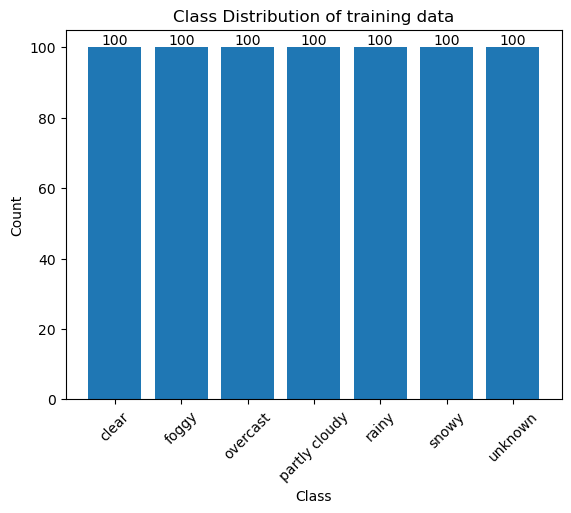

In [34]:
# Plot the distribution
fig, ax = plt.subplots()
bar_container = ax.bar(classnames, class_counts)
ax.set(xlabel='Class', ylabel='Count', title='Class Distribution of training data')
ax.set_xticklabels(classnames, rotation=45)  # Rotating 45 degrees

ax.bar_label(bar_container, fmt='{:,.0f}')
plt.show()

In [35]:
# Reshape images back to their original shape before fitting the model
def preprocess_images(images, labels):
    images = tf.reshape(images, [-1, img_height, img_width, n_channels])
    return images, labels

# Apply the preprocessing function to the dataset
balanced_train_ds = balanced_train_ds.map(preprocess_images)

In [39]:
# Input shape
input_data = keras.Input(shape=(224, 224, 3), name='img')

# Pretrained backbone
backbone = keras_cv.models.ResNetBackbone.from_preset("resnet18")

for layer in backbone.layers[:10]:
    layer.trainable = False
    
# Pass the input data through the backbone
backbone_output = backbone(input_data)

# Custom layers
# x = layers.GlobalAveragePooling2D()(backbone_output)
x = layers.Flatten()(backbone_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dropout(0.25)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create the full model
model_undersampling = Model(inputs=input_data, outputs=outputs)

# Print the model summary
model_undersampling.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_net_backbone                │ (None, 7, 7, 512)      │    11,186,112 │
│ (ResNetBackbone)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,406,215 (54.96 MB)

 Trainable params: 14,313,223 (54.60 MB)

 Non-trainable params: 92,992 (363.25 KB)

In [40]:
# Train the model with class weights
model_undersampling.compile(
        # categorical cross entropy loss
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        # adam optimiser
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        # compute the accuracy metric, in addition to the loss 
        metrics=[keras.metrics.sparse_categorical_crossentropy], jit_compile=False)

history = model_undersampling.fit(
    balanced_train_ds,
    batch_size=8,
    epochs=30,
    validation_data=val_ds,
    verbose=True,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)]
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 761ms/step - loss: 2.1886 - sparse_categorical_crossentropy: 2.1887 - val_loss: 1.9635 - val_sparse_categorical_crossentropy: 1.9632
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - loss: 0.9096 - sparse_categorical_crossentropy: 0.9096 - val_loss: 2.0351 - val_sparse_categorical_crossentropy: 2.0362
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - loss: 0.2686 - sparse_categorical_crossentropy: 0.2686 - val_loss: 2.2338 - val_sparse_categorical_crossentropy: 2.2332
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - loss: 0.0694 - sparse_categorical_crossentropy: 0.0694 - val_loss: 2.4991 - val_sparse_categorical_crossentropy: 2.4968
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - loss: 0.0254 - sparse_categorical_crossentropy: 0.0254 - val_loss: 2.7630 - val_sparse_categorical_crossentropy: 2.7641
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - loss: 0.0175 - sparse_categorical_crossentropy: 0.0175 - val_loss: 3.0691 -

In [42]:
y_class_test = np.concatenate([y for x,y in test_ds.as_numpy_iterator()])
y_train_test = np.concatenate([y for x,y in balanced_train_ds.as_numpy_iterator()])


#print(y_class_test.shape)


test_pred = model_undersampling.predict(test_ds)
train_pred = model_undersampling.predict(balanced_train_ds)


#print(test_pred)

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step


Text(0.5, 1.0, 'DCNN, Train F1 Score: 0.035714')

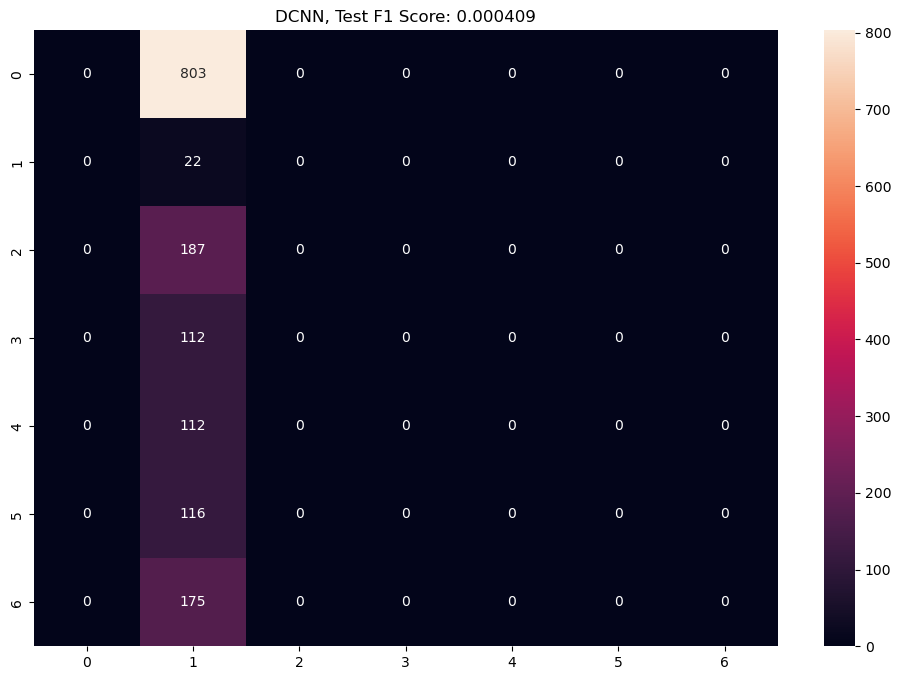

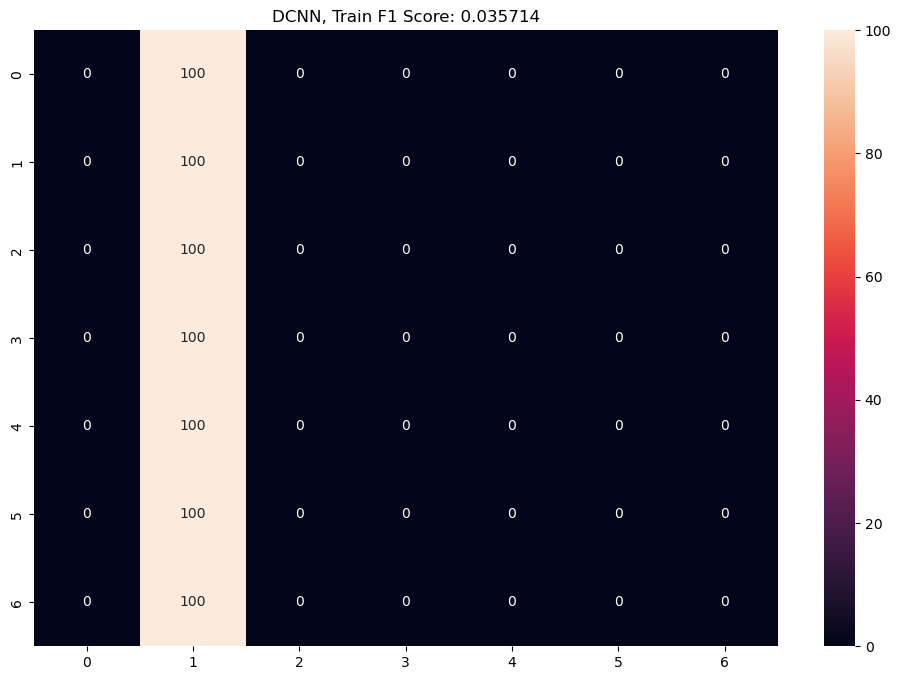

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[12, 8])    
ax = fig.add_subplot(1, 1, 1)
indexes = tf.argmax(test_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_class_test, indexes) 
sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
ax.set_title('DCNN, Test F1 Score: %f' % f1_score(y_class_test, indexes, average='weighted'))

fig = plt.figure(figsize=[12, 8])    
ax = fig.add_subplot(1, 1, 1)
indexes = tf.argmax(train_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_train_test, indexes) 
sns.heatmap(confusion_mtx, annot=True, fmt='g', ax=ax)
ax.set_title('DCNN, Train F1 Score: %f' % f1_score(y_train_test, indexes, average='weighted'))